# Депикселизация и приближения

Эта задача состоит из двух блоков: «депикселизация» и «приближения». Вам предстоит искать минимумы неких функций и, в связи с этим, так как у нас курс алгебры, просим не применять производные, а постараться решить задачи, используя материал лекций. Также в учебных целях при решении просим не пользоваться никакими функциями `numpy` и `scipy`, кроме `np.linalg.solve`, `np.linalg.matrix_rank`, `np.linalg.norm` и базовых функций для создания и работы с матрицами (`np.zeros`, `np.array`, транспонирование, умножение, сложение и т.п.). По возможности воздержитесь от собственноручного написания решения систем методом Гаусса — воспользуйтесь `solve`.

### Депикселизация

Одним из стандартных способов скрытия информации на изображениях и видео является так называемая пикселизация. Метод пикселизации заключается в следующем: скрываемая область изображения делится на квадраты («большие пиксели») заранее выбранного размера, в каждом из них определяется основной цвет, после чего выполняется заливка такого квадрата полностью этим цветом.

![Пикселизованный Асанов](https://imgur.com/fOfe0fh.jpg)

Во многих случая восстановить скрытое действительно невозможно. Но иногда, особенно на видео, с помощью средств линейной алгебры всё-таки можно добиться частичной расшифровки скрытой информации. Вам предлагается восстановить (депикселизировать) некоторое видео.

**Видео.** Дана анимация шириной 100 пикселей и высотой 25: на чёрном фоне прямоугольная область размера 50x20 перемещается из левого угла в правый, на каждом шаге смещаясь на один пиксель вправо и на каждом десятом шаге опускаясь на один пиксель вниз (и одновременно на один вправо). Прямоугольник 60х25 с левым верхним углом с координатами `(20,0)` скрыт пикселизацией за «большими пикселями» размера 5х5. Напомним, что отсчёт координат в изображениях идёт от левого верхнего пикселя `(0,0)`. Вот так выглядит видео (растянутое в 4 раза):

<!-- ![УрФУ мат-мех](https://imgur.com/CMcccRh.gif) -->

<img src="https://imgur.com/CMcccRh.gif" width="400px" />

Нетрудно подсчитать, что это видео содержит 51 кадр. Кадры нумеруются числами от 0 до 50. Цвет каждого пикселя задан целым числом от 0 до 255, кодирующим градацию серого от чисто чёрного (0) до белого (255). Основной цвет «большого пикселя» определяется как среднее арифметическое цветов 25-и настоящих пикселей, входящих в «большой пиксель», округлённое до ближайшего целого.

Каждому пикселю $(x,y) \in [0,49]\times [0,19]$ перемещающейся области сопоставим переменную $z_{20x+y}$; всего $50\cdot 20=1000$ переменных $z_0, z_1, \ldots, z_{999}$. Многие пиксели $z_k$ на тех или иных кадрах «выглядывают» из-за скрытой области и поэтому им можно сопоставить уравнения $z_k = c_k$, где $c_k$ — это значение пикселя на подходящем кадре. Но некоторые пиксели всегда остаются скрытыми. Тем не менее, они не произвольны — кое-какая информация о них даётся «большими пикселями». На каждом кадре информация о скрытых пикселях задаётся уравнениями; например, на кадре с номером 0 цвет левого верхнего «большого пикселя» равен $[\frac{1}{25} \sum_{i=0}^4 \sum_{j=0}^4 z_{20\cdot 20+20i+j}]$.


Кадры анимации даны вам списком `frames[0]`, ..., `frames[50]`. Каждый кадр `frames[i]` — это матрица 100х25. Элемент `frames[i][x,y]` — это цвет пикселя с координатами `(x,y)`.



**1. Система уравнений.** Как было сказано, цвет каждого «большого пикселя» — это округлённое до ближайшего целого среднее арифметическое 25-и настоящих пикселей, скрытых под ним. Предположим, что нам так повезло, что это среднее арифметическое всегда является целым числом, т.е. округление до целого не вносит никаких корректив. Допишите функцию, которая возвращает матруцу $A$ и столбец $b$, такие что решениями соответствующей системы уравнений $Az=b$, где $z = \tiny\left(\begin{array}{c}z_0\\\ldots\\z_{999}\end{array}\right)$, являются только те $z$, которые задают область 50х20, дающую нашу анимацию (вообще говоря, такое $z$ может быть не одно). Мы сознательно не оговариваем число строк в матрице $A$ и в столбце $b$ и что конкретно должно быть в $A$ и $b$ — ваша задача догадаться до этого самим.

In [103]:
def simple_system(frames):
    A = np.zeros((50 * 20 * len(frames), 50 * 20))
    b = np.zeros((50 * 20 * len(frames)))
    for frame in frames:
        num_frame = frames.index(frame)
        shift_x = num_frame
        shift_y = num_frame // 10
        for x_pixel in range(50):
            for y_pixel in range(20):
                b[num_frame * 1000 + x_pixel * 20 + y_pixel] = frame[shift_x + x_pixel][shift_y + y_pixel]

                if x_pixel + shift_x < 20 or x_pixel + shift_x >= 80:
                    A[num_frame * 1000 + x_pixel * 20 + y_pixel][x_pixel * 20 + y_pixel] = 1
                    continue

                width_5x5_pixel = 5
                height_5x5_pixel = 5
                x_5x5_pixel = shift_x + x_pixel - (shift_x + x_pixel) % width_5x5_pixel
                y_5x5_pixel = shift_y + y_pixel - (shift_y + y_pixel) % height_5x5_pixel
                
                if shift_x > x_5x5_pixel:
                    width_5x5_pixel -= (shift_x - x_5x5_pixel)
                    x_5x5_pixel = shift_x
                if shift_y > y_5x5_pixel:
                    height_5x5_pixel -= (shift_y - y_5x5_pixel)
                    y_5x5_pixel = shift_y
                if x_5x5_pixel + 5 > shift_x + 50:
                    width_5x5_pixel -= (x_5x5_pixel + 5 - shift_x - 50)
                if y_5x5_pixel + 5 > shift_y + 20:
                    height_5x5_pixel -= (y_5x5_pixel + 5 - shift_y - 20)

                for x_picture in range(x_5x5_pixel - shift_x, x_5x5_pixel - shift_x + width_5x5_pixel):
                    for y_picture in range(y_5x5_pixel - shift_y, y_5x5_pixel - shift_y + height_5x5_pixel):
                        A[num_frame * 1000 + x_pixel * 20 + y_pixel][x_picture * 20 + y_picture] = 0.04
    return [A, b]

(Продолжение задания) К сожалению, округление до ближайшего целого при вычислении цвета «больших пикселей» действительно вносит коррективы, и поэтому полученная вами система $Az=b$ в реальности наверняка не имеет решений. Осталось это проверить. Допишите функцию, которая возвращает `True`, если система $Az=b$ имеет решение, и `False` в противном случае. В учебных целях вам запрещается писать алгоритм Гаусса самостоятельно. Подсказка: используйте `np.linalg.matrix_rank`.

In [104]:
def is_consistent_system(A, b):
    return np.linalg.matrix_rank(A) == np.linalg.matrix_rank(np.column_stack((A,b)))

**2. Приближённое решение системы.** Хоть система $Az=b$ и не имеет точных решений, но сама картинка, скрытая пикселизацией (и которую нужно найти), в некотором смысле является приближённым решением (будучи закодированной в столбец $z$, как было описано выше). Значит, надо найти наилучшее приближение решения системы. Вспомните, как это делается, и выполните это задание.

Допишите функцию, которая по матрицам `A` и `b`, полученным вами с помощью функции `simple_system`, вычисляет приближённое в каком-то адекватном смысле решение системы $Az = b$ и возвращает соответствующую матрицу 50x20, задающую значения пикселей искомой области 50х20. Все элементы 50х20 матрицы должны быть целыми числами от 0 до 255 (просто все значения вне отреза $[0,255]$ преобразуйте либо в 0, либо в 255).

In [105]:
def depixelate_region50x20(A, b):
    a = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, b))
    a = np.reshape(a, (50, 20))
    for i in range (50):
        for j in range(20):
            if a[i][j] < 0:
                a[i][j] = 0
            if a[i][j] > 255:
                a[i][j] = 255
    return a


### Приближения

**3. Предсказание оценок.** Вам дана база с данными о студентах мат-меха прошлых лет. Студенту с номером $i$ сопоставлены пять оценок: ОГЭ по математике $a_i$, ЕГЭ по русскому языку $b_i$, ЕГЭ по математике $c_i$, средняя оценка в аттестате $d_i$, средняя оценка диплома об окончании мат-меха $f_i$ (0, если не закончил). УрФУ решил применить машинное обучение, чтобы не тратить попусту 4–6 лет, а предсказывать оценку $f_i$ сразу после поступления абитуриента по известным $a_i, b_i, c_i, d_i$. Представьте какая экономия, ведь теперь можно уволить всех преподавателей! Вам нужно «обучить» машину делать предсказания.

Порассуждаем: возможно, $f_i$ будет примерно пропорционально ЕГЭ по математике, т.е. $f_i \approx w_1 c_i + w_2$ для каких-то $w_1,w_2 > 0$ и всех номеров студентов $i$... или, может, все математики безграмотные и вообще $f_i$ обратно пропорционально $b_i$, т.е. $f_i \approx w_1 b_i + w_2$ для каких-то $w_1 < 0$, $w_2 > 0$ и всех $i$... или, может, всё определялось ОГЭ, когда абитуриент ещё интересовался учёбой... Чтобы выявить истинную зависимость, расставим «весовые» коэффициенты $\{w_j\}_{j=1}^5$ так, чтобы $w_1 a_i + w_2 b_i + w_3 c_i + w_4 d_i + w_5 \approx f_i$. Если удастся выбрать числа $\{w_j\}_{j=1}^5$ так, чтобы это приближённое равенство выполнялось для большинства прошлых студентов, то резонно предположить, что $w_1 a_i + w_2 b_i + w_3 c_i + w_4 d_i + w_5$ хорошо предскажет итог и для абитуриента. Да, это грубое линейное предположение, но на удивление оно нередко хорошо работает на практике. Конечно, для любого набора $\{w_j\}_{j=1}^5$ в данных обычно находится студент $i$ с «отклонением»: $|w_1 a_i + w_2 b_i + w_3 c_i + w_4 d_i + w_5 - f_i| > 0$. Ваша задача — минимизировать «совокупную величину» отклонений, а именно, допишите функцию, возвращающую набор $\{w_j\}_{j=1}^5$, для которого сумма квадратов отклонений, т.е. $\sum_i (w_1 a_i + w_2 b_i + w_3 c_i + w_4 d_i + w_5 - f_i)^2$ (сумма берётся по всем студентам из базы), минимальна. Т.е. неформально задача — «приблизить» наблюдаемую зависимость линейным отображением; иллюстрация двумерного приближения (наш случай пятимерный):

![Линейное приближение](https://imgur.com/lkpfqCn.png)

Подсказка: пусть $h = \tiny\left(\begin{array}{c}h_1\\\ldots\\h_n\end{array}\right)$ и $f = \tiny\left(\begin{array}{c}f_1\\\ldots\\f_n\end{array}\right)$, обратите внимание на равенство $|h - f|^2 = \sum_{i=1}^n (h_i - f_i)^2$ и его схожесть с минимизируемой суммой.

In [106]:
def predictor_coefficients(students_data):
    A = np.zeros((len(students_data), 5))
    b = np.zeros ((len(students_data), 1))
    for i in range(len(students_data)):
        for j in range(4):
            A[i][j] = students_data[i][j]
        A[i][-1] = 1
        b[i] = students_data[i][-1]
    w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, b))
    return w

**4. Кривые на сенсорной панели.**
С точки зрения компьютера или телефона данные от сенсорной панели — это координаты точек прикосновения на плоскости панели и соответствующее время касания. Проблема в том, что устройства довольно несовершенны, так что даже если вы неспеша чертите на панели пальцем прямую линию, реально устройство получит некое облако точек вокруг этой прямой, подобное тому, что изображено на рисунке в предыдущей подзадаче. Но многие программы интересуют не отдельные точки касания, а то, какую линию хотел начертить пользователь. Алгоритмы угадывания линий по данным с сенсоров весьма разнообразны, но большинство из них разбивают неким хитрым образом данные на куски (не будем вдаваться в детали как) и для каждого куска как-то приблизительно восстанавливают кривую. Как же именно? Рассмотрим один из методов.

Вам дан набор троек $\{(x_i,y_i,t_i)\}_{i=1}^n$ (тот самый кусок), такой что $(x_i, y_i)$ — это координаты точки $i$-го прикосновения, а $t_i$ — это время, когда произошло касание, причём $t_1 < t_2 < \cdots < t_n$. Искомая кривая на плоскости задаётся параметрически как функция времени: $t \mapsto (x(t), y(t))$. Вам надо построить два многочлена третьей степени $x(t) = a_x t^3 + b_x t^2 + c_x t + d_x$ и $y(t) = a_y t^3 + b_y t^2 + c_y t + d_y$, которые некоторым наилучшим образом восстанавливают подразумевавшуюся пользователем кривую, т.е., неформально, должно получиться $x(t_i) \approx x_i$ и $y(t_i) \approx y_i$ для большинства троек $(x_i, y_i, t_i)$. Почему именно многочлены и именно третьей степени? В основном, потому что на практике они хорошо выглядят. Один из стандартных способов определить «наилучшее приближение» следующий: многочлены $x(t)$ и $y(t)$ должны быть подобраны так, чтобы сумма квадратов отклонений $\sum_{i=1}^n (x(t_i) - x_i)^2 + \sum_{i=1}^n (y(t_i) - y_i)^2$ была минимальна. Допишите функцию, которая по набору $\{(x_i,y_i,t_i)\}_{i=1}^n$ возвращает коэффициенты $a_x,b_x,c_x,d_x$ и $a_y,b_y,c_y,d_y$ многочленов $x(t)$ и $y(t)$, минимизирующих сумму квадратов отклонений.

In [107]:
def cubic_approximation(data):
    Ax = np.zeros((len(data), 4))
    bx = np.zeros((len(data), 1))
    Ay = np.zeros((len(data), 4))
    by = np.zeros((len(data), 1))
    for i in range(len(data)):
        [x, y, t] = data[i]
        j = 0
        for degree in range(3, -1, -1):
            Ax[i][j] = t**degree
            Ay[i][j] = t**degree
            j += 1
        bx[i] = x
        by[i] = y
    answer_x = np.linalg.solve(np.dot(Ax.T, Ax), np.dot(Ax.T, bx))
    answer_y = np.linalg.solve(np.dot(Ay.T, Ay), np.dot(Ay.T, by))
    return [answer_x, answer_y]

## Тестирование

Осталось проверить, проходят ли ваши решения первоначальное тестирование. Тесты выводят депикселизованное изображение. На изображении будут неизбежно видны артефакты восстановления, но, тем не менее, скрытый текст должен быть очень хорошо распознаваем. Также тесты выводят графики многочленов, приближающих $x$ и $y$ координаты некоторого набора точек. Выполните весь код (Cell -> Run All или Runtime -> Run All или другим способом, работающим в вашей среде) и посмотрите вердикт внизу страницы. В тестирующем коде разбираться не нужно!

Первое задание прошло все тесты
Второе задание прошло все тесты
Третье задание прошло все тесты
Четвёртое задание прошло все тесты


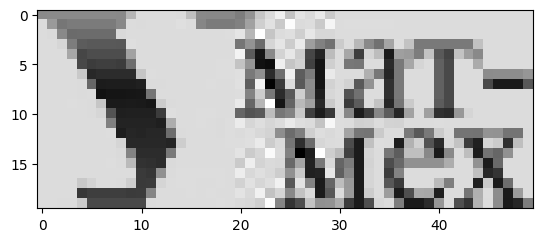

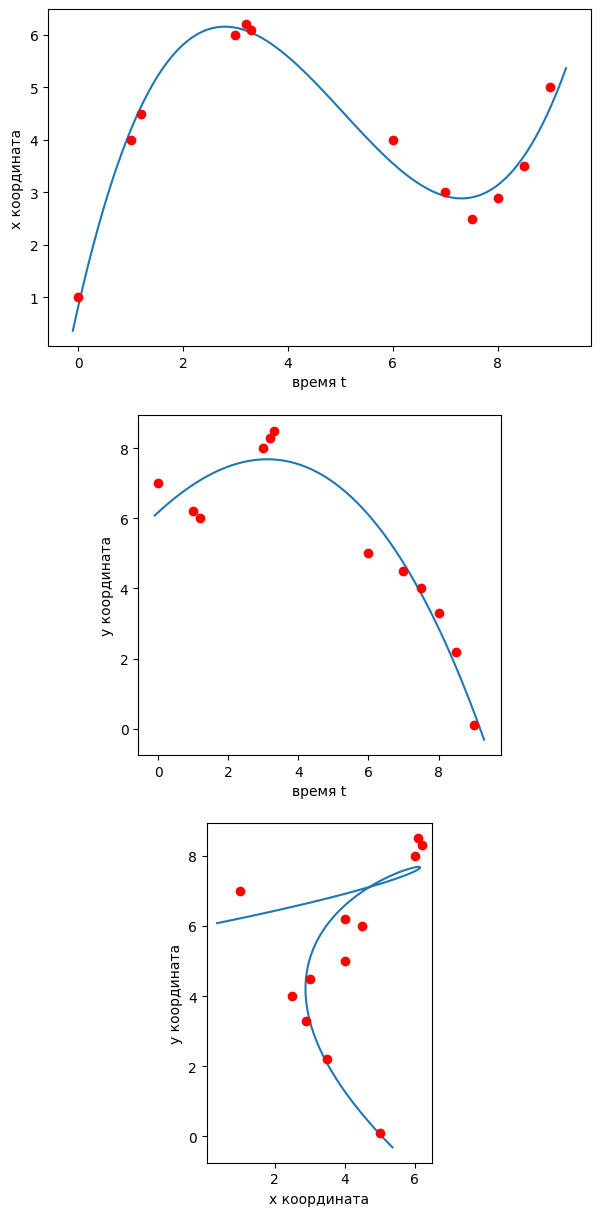

In [108]:
try:
    import numpy as np, matplotlib.pyplot as plt, requests, imageio, itertools
except ImportError:
    !pip3 install imageio matplotlib requests
    import numpy as np, matplotlib.pyplot as plt, requests, imageio, itertools
%matplotlib inline

timg = np.zeros([50, 20])
for x, y in itertools.product(range(50), range(20)):
    timg[x, y] = 25 * ((20*x + y) // 7) % 11
frames = []
for k in range(51):
    frames.append(np.zeros([100, 25]))
    for x, y in itertools.product(range(50), range(20)):
        frames[-1][k + x, k // 10 + y] = timg[x, y]
    for i, j in itertools.product(range(12), range(5)):
        acc = 0
        for dx, dy in itertools.product(range(5), range(5)):
            acc += frames[-1][20 + 5*i + dx, 5*j + dy]
        for dx, dy in itertools.product(range(5), range(5)):
            frames[-1][20 + 5*i + dx, 5*j + dy] = acc / 25
[A, b] = simple_system(frames)
zs = timg.flatten() 
if np.linalg.norm(A @ zs - b) >= 1e-8:
    zs = timg.T.flatten()
succ = False
if A.shape[0] > 0 and np.linalg.norm(A @ zs - b) < 1e-8:
    succ = True
    for x, y in [(25, 5), (1, 0), (49, 19), (0, 30), (2, 20) ]:
        zs[20 * x + y] += 25
        if np.linalg.norm(A @ zs - b) < 1e-8:
            succ = False
        zs[20 * x + y] -= 25
    for i, j in [(20 * 49, 20 * 49 + 1), (20 * 49 + 18, 20 * 49 + 19), (0, 50),
                 (50*0 + 49, 50*1 + 49), (50*18 + 49, 50*19 + 49), (50*18, 50*19)]:
        zs[i] += 25
        zs[j] -= 25
        if np.linalg.norm(A @ zs - b) < 1e-8:
            succ = False
        zs[i] -= 25
        zs[j] += 25

if succ:
    tests = [{'A' : np.array([[0,2], [3,-1], [-6,0]]), 'b' : np.array([4,1,7])},
         {'A' : np.array([[0,1,1], [3,0.1,0]]), 'b' : np.array([2,1])}]
    if is_consistent_system(tests[0]['A'], tests[0]['b']):
        print('Первое задание не прошло тест: A =', tests[0]['A'], 'b =', tests[0]['b'])
    elif not is_consistent_system(tests[1]['A'], tests[1]['b']):
        print('Первое задание не прошло тест: A =', tests[1]['A'], 'b =', tests[1]['b'])
    else:
        print('Первое задание прошло все тесты')
else:
    print('Первое задание не прошло тест')

if np.linalg.norm(timg - depixelate_region50x20(A, b)) < 1e-8:
    print('Второе задание прошло все тесты')
else:
    print('Второе задание не прошло тест')

response = requests.get('https://imgur.com/CMcccRh.gif')
reader = imageio.get_reader(response.content)
frames = [frame.T if len(frame.shape) == 2 else frame[:,:,0].T for frame in reader]
[A, b] = simple_system(frames)
#print('Az=b', ('для gif имеет решение (что-то не так!)' if is_consistent_system(A, b) 
#               else 'для gif не имеет решений (так и должно быть)'))
res = depixelate_region50x20(A, b)
plt.figure()
plt.imshow(res.T, cmap='gray')


#for a,b,c,d in [(4,5,4.5,4.9), (5,3.2,5,4.4), (5,4.2,4.5,4.6), 
#            (4.5,4.5,4.5,4.5), (5,5,5,5), (3,3,3,3), (4,4,4,4)]:
#    f = 0.05*a + 0.11*b + 0.7*c + 0.2*d + 0.3
#    print('[',a,b,c,d,f,'],')
students_data = [[ 4, 5, 4.5, 4.9, 5.18+0.4 ], [ 5, 3.2, 5, 4.4, 5.282-0.1 ], [ 5, 4.2, 4.5, 4.6, 5.082+2 ],
    [ 4.5, 4.5, 4.5, 4.5, 5.07-0.3 ], [ 5, 5, 5, 5, 5.6+0.0 ], [ 3, 3, 3, 3, 3.48-0.1 ], [ 4, 4, 4, 4, 4.54-0.3 ]]
w = predictor_coefficients(students_data)
deviation = 0
for a,b,c,d,f in students_data:
    deviation += (a*w[0] + b*w[1] + c*w[2] + d*w[3] + w[4] - f)**2
if abs(deviation - 0.06685714285714356) < 1e-8:
    print('Третье задание прошло все тесты')
else:
    print('Третье задание не прошло тест')

xs = [1, 4, 4.5, 6, 6.2, 6.1, 4, 3, 2.5, 2.9, 3.5, 5 ]
ys = [7,6.2,  6, 8, 8.3, 8.5, 5, 4.5, 4, 3.3, 2.2,0.1]
ts = [0, 1, 1.2, 3, 3.2, 3.3, 6, 7, 7.5,  8, 8.5, 9 ]
[xcoef, ycoef] = cubic_approximation(list(zip(xs, ys, ts)))
xdeviation = ydeviation = 0
for x, t in zip(xs, ts):
    xdeviation += (xcoef[0] * t**3 + xcoef[1] * t**2 + xcoef[2] * t + xcoef[3]  - x)**2
for y, t in zip(ys, ts):
    ydeviation += (ycoef[0] * t**3 + ycoef[1] * t**2 + ycoef[2] * t + ycoef[3]  - y)**2
if abs(xdeviation - 0.7342617491832826) < 1e-8 and abs(ydeviation - 5.432255609097543) < 1e-8:
    print('Четвёртое задание прошло все тесты')
else:
    print('Четвёртое задание не прошло тест')

tdraw = np.linspace(-0.1,9.3, num=100)
plt.figure(figsize=(7,15))

fx = [xcoef[0] * t**3 + xcoef[1] * t**2 + xcoef[2] * t + xcoef[3] for t in tdraw]
ax = plt.subplot(3, 1, 1)
ax.set_aspect('equal')
plt.xlabel('время t')
plt.ylabel('x координата')
plt.plot(tdraw, fx, ts, xs, 'ro')

fy = [ycoef[0] * t**3 + ycoef[1] * t**2 + ycoef[2] * t + ycoef[3] for t in tdraw]
ax = plt.subplot(3, 1, 2)
ax.set_aspect('equal')
plt.xlabel('время t')
plt.ylabel('y координата')
plt.plot(tdraw, fy, ts, ys, 'ro')

ax = plt.subplot(3, 1, 3)
ax.set_aspect('equal')
plt.xlabel('x координата')
plt.ylabel('y координата')
plt.plot(fx, fy, xs, ys, 'ro')

plt.subplots_adjust(hspace=0.2)
plt.show()